# Regressão Logística I
## Tarefa II

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

In [67]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.formula.api as smf

from sklearn.metrics import roc_curve
from sklearn import metrics

from scipy.stats import ks_2samp


In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

#Criando Flag_doente
df = pd.read_csv(url, 
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])
df['flag_doente'] = (df['num']!=0).astype('int64')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          303 non-null    float64
 1   sex          303 non-null    float64
 2   cp           303 non-null    float64
 3   trestbps     303 non-null    float64
 4   chol         303 non-null    float64
 5   fbs          303 non-null    float64
 6   restecg      303 non-null    float64
 7   thalach      303 non-null    float64
 8   exang        303 non-null    float64
 9   oldpeak      303 non-null    float64
 10  slope        303 non-null    float64
 11  ca           303 non-null    object 
 12  thal         303 non-null    object 
 13  num          303 non-null    int64  
 14  flag_doente  303 non-null    int64  
dtypes: float64(11), int64(2), object(2)
memory usage: 35.6+ KB


1. Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada. 
**Monte** a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

In [23]:
#Função para analise bivariada
def analise_bivariada(data, var_r, var_exp, var_ratio = 'All'):
    tab = pd.crosstab(data[var_exp], data[var_r], margins=True)
    tab['probabilidade'] = tab[1]/tab['All']
    tab['chance'] = tab[1]/tab[0]
    tab[f'RC_vs_{var_ratio}'] = tab['chance']/tab.loc[var_ratio, 'chance']
    tab['log_odds'] = np.log(tab['chance'])
    tab['WOE'] = np.log(tab[f'RC_vs_{var_ratio}'])
    return tab

In [24]:
tab = analise_bivariada(data = df, var_r = 'flag_doente', var_exp = 'sex')
tab

flag_doente,0,1,All,probabilidade,chance,RC_vs_All,log_odds,WOE
sex,,,,,,,,
0.0,72,25,97,0.257732,0.347222,0.409672,-1.057790,-0.892398
1.0,92,114,206,0.553398,1.239130,1.461996,0.214410,0.379802
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


In [25]:
tab = analise_bivariada(data = df, var_r = 'flag_doente', var_exp = 'cp')
tab

flag_doente,0,1,All,probabilidade,chance,RC_vs_All,log_odds,WOE
cp,,,,,,,,
1.0,16,7,23,0.304348,0.437500,0.516187,-0.826679,-0.661286
2.0,41,9,50,0.180000,0.219512,0.258993,-1.516347,-1.350955
3.0,68,18,86,0.209302,0.264706,0.312315,-1.329136,-1.163743
4.0,39,105,144,0.729167,2.692308,3.176536,0.990399,1.155791
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


In [26]:
tab = analise_bivariada(data = df, var_r = 'flag_doente', var_exp = 'fbs')
tab

flag_doente,0,1,All,probabilidade,chance,RC_vs_All,log_odds,WOE
fbs,,,,,,,,
0.0,141,117,258,0.453488,0.829787,0.979030,-0.186586,-0.021193
1.0,23,22,45,0.488889,0.956522,1.128558,-0.044452,0.120941
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


2. Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  
    Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar. Defina um valor '*default*' de 5 grupos para este parâmetro.  

In [42]:
#Função Analise Bivariada com categorias
def analise_bivariada_categorias(data, var_r, var_exp, var_ratio = 'All', corte = 5):
    cut = pd.qcut(data[var_exp], corte)
    tab = pd.crosstab(cut, data[var_r], margins=True)
    tab['probabilidade'] = tab[1]/tab['All']
    tab['chance'] = tab[1]/tab[0]
    tab[f'RC_vs_{var_ratio}'] = tab['chance']/tab.loc[var_ratio, 'chance']
    tab['log_odds'] = np.log(tab['chance'])
    tab['WOE'] = np.log(tab[f'RC_vs_{var_ratio}'])
    return tab

In [43]:
tab = analise_bivariada_categorias(df, 'flag_doente', 'age')
tab

flag_doente,0,1,All,probabilidade,chance,RC_vs_All,log_odds,WOE
age,,,,,,,,
"(28.999, 45.0]",47,16,63,0.253968,0.340426,0.401653,-1.077559,-0.912166
"(45.0, 53.0]",42,22,64,0.343750,0.523810,0.618020,-0.646627,-0.481235
"(53.0, 58.0]",32,39,71,0.549296,1.218750,1.437950,0.197826,0.363218
"(58.0, 62.0]",13,32,45,0.711111,2.461538,2.904261,0.900787,1.066179
"(62.0, 77.0]",30,30,60,0.500000,1.000000,1.179856,0.000000,0.165392
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


3. Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.

**Interprete os parâmetros.**

In [51]:
#Regressão logistica
reglog = smf.logit('flag_doente ~ C(sex) + C(cp, Treatment(4)) + trestbps', data=df).fit()
reglog.summary()

Optimization terminated successfully.
         Current function value: 0.493233
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      297
Method:                           MLE   Df Model:                            5
Date:                Thu, 31 Aug 2023   Pseudo R-squ.:                  0.2849
Time:                        19:20:20   Log-Likelihood:                -149.45
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 4.908e-24
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -3.5000      1.162     -3.012      0.003      -5.778      -1.222
C(sex)[T.1.0]                  1.6297      0.340      4.794      0.000       0.963       2.296
C(cp, Treatment(4))[T.1.0]    -2.4260      0.539     -4.501      0.000      -3.482      -1.370
C(cp, Treatment(4))[T.2.0]    -2.6167      0.442     -5.925      0.000      -3.482      -1.751
C(cp, Treatment(4))[T.3.0]    -2.4195      0.353     -6.860      0.000      -3.111      -1.728
trestbps                       0.0259      0.008      3.114      0.002       0.010       0.042
==============================================================================================
"""

4. Avalie o seu modelo quanto a **calibragem**:
- Calcule a probabilidade de evento predita segundo o seu modelo
- Categorize essa probabilidade em G=5 grupos
- Calcule a probabilidade de evento predita média por grupo
- Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo
- Compare graficamente o valor eperado versus observado para a taxa de maus por grupo

In [52]:
#Colocando preditos no dataframe
df['predito'] = reglog.predict(df)
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente,cut,predito
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0,"(62.0, 77.0]",0.368788
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1,"(62.0, 77.0]",0.906991
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1,"(62.0, 77.0]",0.775651
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0,"(28.999, 45.0]",0.284996
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0,"(28.999, 45.0]",0.060273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1,1,"(28.999, 45.0]",0.190813
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2,1,"(62.0, 77.0]",0.865607
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3,1,"(53.0, 58.0]",0.817535
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1,1,"(53.0, 58.0]",0.060273


In [58]:
#Separando em Grupos e fazendo groupby
cat_pred = pd.qcut(df['predito'], 5, duplicates='drop')
group_reg = df.groupby(cat_pred)
qualid = group_reg[['flag_doente']].count()
qualid

,flag_doente
predito,
"(0.0288, 0.159]",61
"(0.159, 0.287]",60
"(0.287, 0.534]",61
"(0.534, 0.797]",63
"(0.797, 0.927]",58


In [59]:
#Media valores preditos
qualid['predito'] = group_reg['predito'].mean()
qualid

,flag_doente,predito
predito,,
"(0.0288, 0.159]",61,0.076784
"(0.159, 0.287]",60,0.235353
"(0.287, 0.534]",61,0.408871
"(0.534, 0.797]",63,0.727510
"(0.797, 0.927]",58,0.852082


In [60]:
#Media doentes
qualid['pct_doente'] = group_reg['flag_doente'].mean()
qualid

,flag_doente,predito,pct_doente
predito,,,
"(0.0288, 0.159]",61,0.076784,0.049180
"(0.159, 0.287]",60,0.235353,0.233333
"(0.287, 0.534]",61,0.408871,0.409836
"(0.534, 0.797]",63,0.727510,0.793651
"(0.797, 0.927]",58,0.852082,0.810345


Text(0.5, 0, 'Grupo')

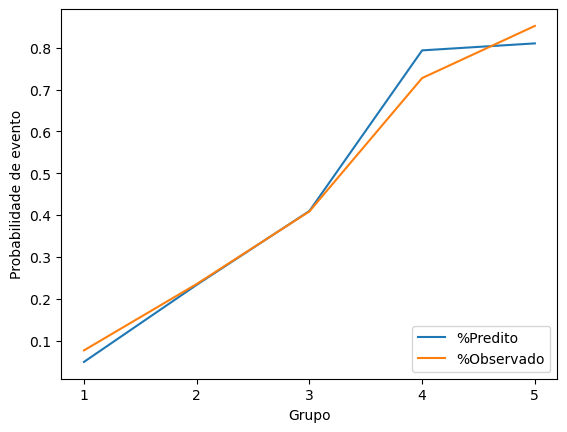

In [61]:
#Plotando oque foi predito com o que foi observado
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax = qualid['pct_doente'].plot(label='%Predito')
ax = qualid['predito'].plot(label='%Observado')

ticks = ax.set_xticks([0, 1, 2, 3, 4])
labels = ax.set_xticklabels([1, 2, 3, 4, 5])
ax.legend(loc="lower right")
ax.set_ylabel('Probabilidade de evento')
ax.set_xlabel('Grupo')


5. Avalie o seu modelo quanto a discriminação calculando acurácia, GINI e KS.

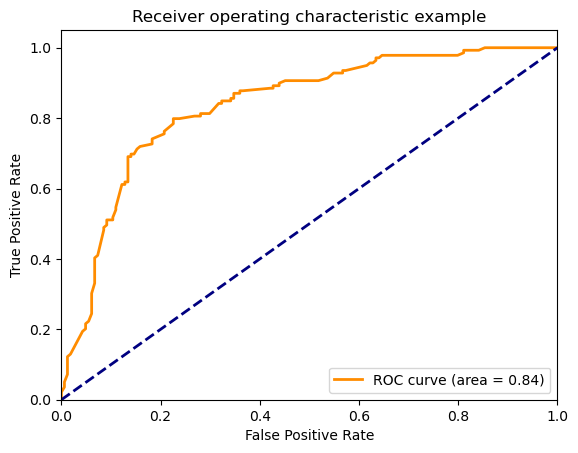

In [62]:
#Plotando Roc
fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito'])

plt.figure()
lw = 2

fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito'])
auc_ = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Text(0, 0.5, 'Função Distribuição Acumulada')

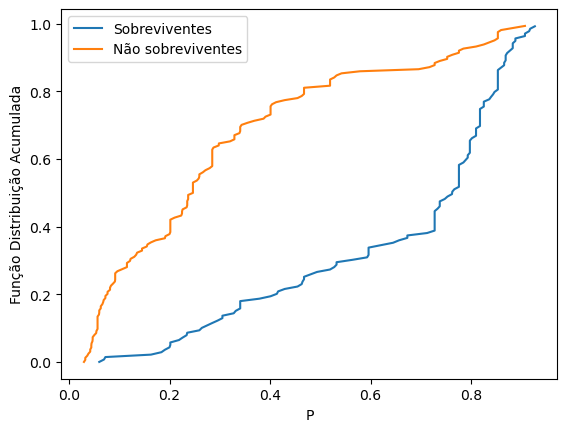

In [65]:
#Plotando KS
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

score_pop1 = df.loc[df['flag_doente']==1,'predito']
ax.plot(np.sort(score_pop1), np.linspace(0, 1, len(score_pop1), endpoint=False), label='Sobreviventes')

score_pop2 = df.loc[df['flag_doente']!=1,'predito']
ax.plot(np.sort(score_pop2), np.linspace(0, 1, len(score_pop2), endpoint=False), label='Não sobreviventes')
ax.legend()

ax.set_xlabel('P')
ax.set_ylabel('Função Distribuição Acumulada')


In [66]:
#Indicadores
acc = metrics.accuracy_score(df['flag_doente'], df['predito']>.5)
print('Acurácia: {0:.2f}%'.format(acc*100))

#AUC
fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito'])
auc_ = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc_ -1
#KS
ks = ks_2samp(df.loc[df['flag_doente'] == 1, 'predito'], df.loc[df['flag_doente'] != 1, 'predito']).statistic

print('KS: {0:.2f}% \nAUC: {1:.2f}% \nGINI: {2:.2f}%'
      .format(ks*100, auc_*100, gini*100))

Acurácia: 77.56%
KS: 57.30% 
AUC: 83.56% 
GINI: 67.13%


6. tente melhorar o modelo obtido, por exemplo inserindo ou removendo variáveis.  
    Avalie as características do seu modelo (calibragem e acurácia).

In [68]:
df.head(1)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente,cut,predito
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0,"(62.0, 77.0]",0.368788


In [90]:
reglog = smf.logit('flag_doente ~ sex + C(cp, Treatment(4)) + trestbps + chol + thalach + exang + slope ', data=df).fit()
reglog.summary()

Optimization terminated successfully.
         Current function value: 0.418923
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      293
Method:                           MLE   Df Model:                            9
Date:                Thu, 31 Aug 2023   Pseudo R-squ.:                  0.3926
Time:                        19:58:56   Log-Likelihood:                -126.93
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.036e-30
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -2.5914      1.955     -1.326      0.185      -6.423       1.240
C(cp, Treatment(4))[T.1.0]    -2.1788      0.601     -3.627      0.000      -3.356      -1.001
C(cp, Treatment(4))[T.2.0]    -1.7964      0.494     -3.637      0.000      -2.764      -0.828
C(cp, Treatment(4))[T.3.0]    -1.9037      0.396     -4.811      0.000      -2.679      -1.128
sex                            2.0006      0.401      4.991      0.000       1.215       2.786
trestbps                       0.0236      0.009      2.549      0.011       0.005       0.042
chol                           0.0069      0.003      2.155      0.031       0.001       0.013
thalach                       -0.0290      0.009     -3.309      0.001      -0.046      -0.012
exang                          0.7435      0.371      2.005      0.045       0.017       1.470
slope                          0.8032      0.273      2.942      0.003       0.268       1.338
==============================================================================================
"""

In [91]:
df['predito'] = reglog.predict(df)

acc = metrics.accuracy_score(df['flag_doente'], df['predito']>.5)
print('Acurácia: {0:.2f}%'.format(acc*100))

#AUC
fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito'])
auc_ = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc_ -1
#KS
ks = ks_2samp(df.loc[df['flag_doente'] == 1, 'predito'], df.loc[df['flag_doente'] != 1, 'predito']).statistic

print('KS: {0:.2f}% \nAUC: {1:.2f}% \nGINI: {2:.2f}%'
      .format(ks*100, auc_*100, gini*100))

Acurácia: 79.21%
KS: 60.45% 
AUC: 88.63% 
GINI: 77.25%
